# Binomial Tree Method

The Binomial Tree Model, introduced by Cox, Ross, and Rubinstein in 1979, is a foundational method for option pricing. It offers a discrete-time framework to model the evolution of an asset’s price over time, making it especially useful for valuing both European and American-style options.

In this model, at each time step, the underlying asset price can either move up by a factor $u$ or move down by a factor $v$, creating a branching structure that represents all possible future price paths.

Starting from an initial price $S_0$, after one time step the asset can take on one of two values:

* $S_0 * u$ (up-move)

* $S_0 * v$ (down-move)

This process continues at each subsequent time step. After two steps, for example, the asset may reach:

* $S_0 * u²$ (two up-moves)

* $S_0 * uv$ (one up and one down, in any order)

* $S_0 * v²$ (two down-moves)

As the number of time steps increases, a tree-like structure forms, where each node represents a possible asset price at a given point in time, and each node branches into two future possibilities. This binomial tree provides an intuitive and flexible way to simulate price evolution across multiple periods.

The strength of the binomial model lies in its adaptability. It incorporates key variables such as time to maturity, volatility, interest rates, and early exercise features. The model calculates the option’s value by working backward from the expiration date to the present, determining the option price at each node based on expected future values and risk-neutral probabilities.

This backward induction approach is particularly useful for pricing American options, where the option holder has the right to exercise the option before expiration. The model evaluates whether early exercise is optimal at each node, making it an effective tool for accurately capturing the value of complex derivative products.

**Import Libraries**

We'll import the required libraries that we'll use in this example.

In [4]:
import numpy as np
from numpy import zeros, maximum, power, sqrt, around

**Risk Neutral Probability**

Risk-neutral measure is a probability measure such that each share price today is the discounted expectations of the share price. From Paul's lecture, we know the formula for $u$, $v$, $p\space'$ and $V$ are as follows, 

$ u = 1+ {\sigma\sqrt{\delta t}} $

$ v = 1- {\sigma\sqrt{\delta t}} $

The underlying instrument will move up or down by a specific factor $u$ or $v$ per step of the tree where $u$ $\geq$ 1 and 0 $<$ $v$ $\leq$ 1. 

$ p\space' = \frac{1}{2} + \frac{r \sqrt\delta t}{2\sigma} $

where, $p\space'$ the risk-neutral probability.

$ V = \frac{1}{1+r\delta t}\space (p\space' V^{+} + (1-p\space')V^{-}) $

where, $V$ is the option value which is present value of some expectation : sum probabilities multiplied by events. 

## Building Binomial Tree

Next, we will build a binomial tree using the risk neutral probability. Building a tree is a multi step process which involves.

**Step 1**: Draw a n-step tree

**Step 2**: At the end of n-step, estimate terminal prices

**Step 3**: Calculate the option value at each node based on the terminal price, exercise price and type

**Step 4**: Discount it back one step, that is, from n to n-1, according to the risk neutral probability

**Step 5**: Repeat the previous step until we find the final value at step 0

### Binomial Pricing Model
Let's now define a binomial option pricing class. 

In [ ]:
# Create a user defined function
def binomial_option(spot: float, strike: float, rate: float, sigma: float, time: float, steps: int, output: int=0) -> np.ndarray:
    
    """
    binomial_option(spot, strike, rate, sigma, time, steps, output=0)
    Function for building binomial option tree for european call option payoff
    
    Params
    ------
    spot        int or float     - spot price
    strike      int or float     - strike price
    rate        float            - interest rate
    sigma       float            - volatility
    time        int or float     - expiration time
    steps       int              - number of trees
    output      int              - [0: price, 1: payoff, 2: option value, 3: option delta]
    
    Returns
    -------
    out:        ndarray
    An array object of price, payoff, option value and delta specified by the output parameter
    
    """
    
    # params
    dt = time/steps
    u = 1+sigma*sqrt(dt)
    d = 1-sigma*sqrt(dt) # v
    p = 0.5+rate*sqrt(dt)/(2*sigma)
    df = 1/(1+rate*dt)

    # initialize arrays
    px = zeros((steps+1, steps+1))
    cp = zeros((steps+1, steps+1))
    V = zeros((steps+1, steps+1))
    delta = zeros((steps+1, steps+1))
    
    # binomial loop
    # forward loop
    for j in range(steps+1):
        for i in range(j+1):
            px[i,j] = spot * power(u, j-i) * power(d, i)
            cp[i,j] = maximum(px[i,j] - strike, 0)
 
    # reverse loop
    for j in range(steps, -1, -1):
        for i in range(j+1):
            if j == steps:
                V[i,j] = cp[i,j]
                delta[i,j] = 1 if px[i,j] >= strike else 0
            else:
                V[i,j] = df * (p * V[i,j+1] + (1-p) * V[i+1,j+1])
                delta[i,j] = (V[i,j+1] - V[i+1,j+1]) / (px[i,j+1] - px[i+1,j+1])
    
    results = (around(px,2), around(cp,2), around(V,2), around(delta, 4))
    
    return results[output]



**Asset Price Matrix**

In [6]:
# Asset price
px = binomial_option(100,100,0.05,0.2,1,4,output=0)
px

array([[100.  , 110.  , 121.  , 133.1 , 146.41],
       [  0.  ,  90.  ,  99.  , 108.9 , 119.79],
       [  0.  ,   0.  ,  81.  ,  89.1 ,  98.01],
       [  0.  ,   0.  ,   0.  ,  72.9 ,  80.19],
       [  0.  ,   0.  ,   0.  ,   0.  ,  65.61]])

**Payoff Matrix**

In [7]:
# Intrinsic value of call options
cp = binomial_option(100,100,0.05,0.2,1,4,output=1)
cp

array([[ 0.  , 10.  , 21.  , 33.1 , 46.41],
       [ 0.  ,  0.  ,  0.  ,  8.9 , 19.79],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ]])

**Option Price Matrix**

In [8]:
# Option price 
opx = binomial_option(100,100,0.05,0.2,1,4,output=2)
opx

array([[10.29, 15.88, 23.83, 34.33, 46.41],
       [ 0.  ,  3.39,  6.11, 10.99, 19.79],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ]])

**Option Delta Matrix**

In [9]:
# Option delta
d = binomial_option(100,100,0.05,0.2,1,4,output=3)
d

array([[0.6241, 0.8053, 0.9645, 1.    , 1.    ],
       [0.    , 0.3393, 0.5553, 0.9086, 1.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    ]])

**Binominal Option Pricing**

In [10]:
# Binomial Option Price
print(f"European Call Option Price using Binomial Tree Method: {opx[0,0]:.2f}")

European Call Option Price using Binomial Tree Method: 10.29


## Quantmod Option Module

The quantmod option module offers a versatile and comprehensive toolkit for valuing a wide range of financial derivatives. It includes multiple pricing models implemented in Python such as Black-Scholes, Binomial, and Monte Carlo methods, enabling accurate computation of theoretical prices for European, American, and exotic options, including Asian and barrier options.

Built with a clean, object-oriented architecture and leveraging Pydantic for smart function calling and input validation, the module allows users to easily specify input parameters, configure model-specific settings like time steps or simulation paths, handle early exercise features, and generate precise valuations all through a unified and intuitive Python API.

Its flexible design makes it ideal for creating intelligent option agents and building custom MCP servers by harnessing the power of function calling.

Key Features:

* OptionInputs: A structured class to standardize and validate input parameters.

* BlackScholesOptionPricing: Implements the Black-Scholes model for pricing options and calculating Greeks.

* BinomialOptionPricing: Prices options using the binomial tree method, including support for early exercise.

* MonteCarloOptionPricing: Uses Monte Carlo simulation to price European, Asian, and barrier options.

Let's now price the option and print the tree.

In [11]:
# Import Quantmod Option Module
from quantmod.models import OptionInputs, OptionType, ExerciseStyle, BinomialOptionPricing

In [20]:
# Define input parameters
inputs=OptionInputs(
    spot=112,
    strike=100,
    ttm=1,
    rate=0.05,
    volatility=0.2
    )

# Instantiate the BinomialOptionPricing Engine
binomial = BinomialOptionPricing(
    inputs=inputs,
    nsteps=4,
    option_type=OptionType.PUT,
    exercise_style=ExerciseStyle.EUROPEAN,
    output="value",
)

In [21]:
# Print the tree values
print(f"\nOption {binomial.output} tree:")
print(binomial.binomialoption)


Option value tree:
[[ 2.7593  0.7895  0.      0.      0.    ]
 [ 0.      5.1264  1.7297  0.      0.    ]
 [ 0.      0.      9.2183  3.7895  0.    ]
 [ 0.      0.      0.     15.7861  8.3022]
 [ 0.      0.      0.      0.     24.9242]]




Plot the tree:


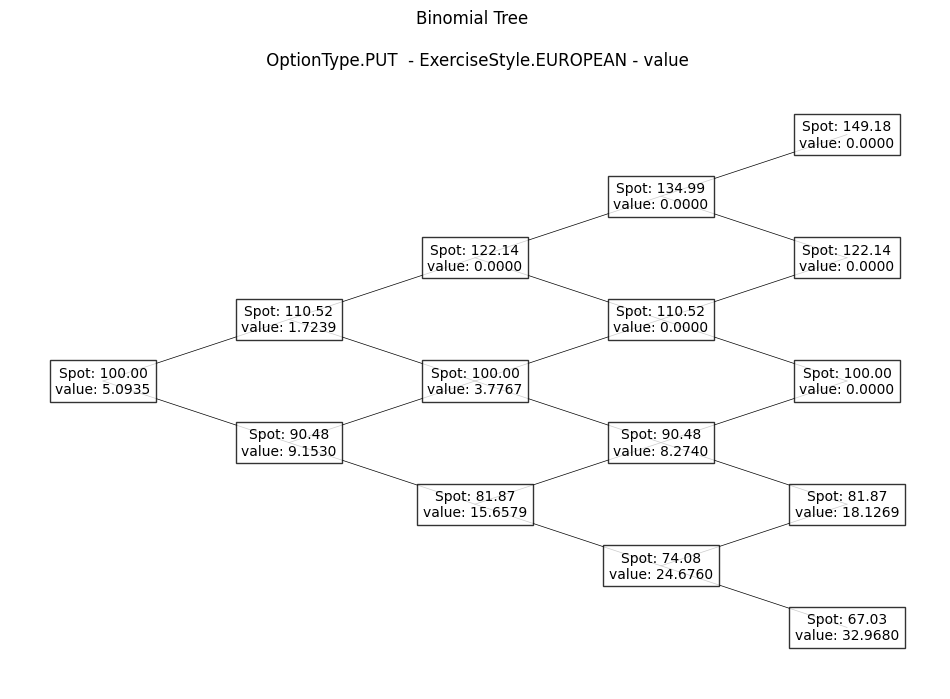

In [ ]:
# Plot the tree
print("\n\nPlot the tree:")
binomial.plot_tree()

In [15]:
# Binomial Option Price
print(f"American Put Option Price using Binomial Tree Method: {binomial.value[0,0]:.2f}")

American Put Option Price using Binomial Tree Method: 5.09


---
[Kannan Singaravelu](https://www.linkedin.com/in/kannansi) | Refer [Quantmod](https://kannansingaravelu.com/quantmod/) and [Numpy](https://docs.scipy.org/doc/numpy/) for more information.